In [1]:
#from google.colab import drive
#drive.mount('/content/google_drive',force_remount=True)

Mounted at /content/google_drive


In [2]:
print('\n-----------------------------------------------------------------------------------------------')
print('( ) Loading libraries')
print('-----------------------------------------------------------------------------------------------')
!python -m pip install geopandas==0.13.0 &> /dev/null
!python -m pip install wget==3.2 &> /dev/null
!python -m pip install rasterstats==0.19.0 &> /dev/null
!python -m pip install simpledbf==0.2.6 &> /dev/null
!python -m pip install rioxarray==0.14.1 &> /dev/null
!python -m pip install fiona==1.9.4 &> /dev/null
!python -m pip install richdem &> /dev/null


-----------------------------------------------------------------------------------------------
( ) Loading libraries
-----------------------------------------------------------------------------------------------


In [3]:
import pandas as pd
import numpy as np
import os
import json
import geopandas as gpd
import shutil
import matplotlib.pyplot as plt
from glob import glob
import rioxarray as rxr
import richdem as rd
import wget
import zipfile
# Earth Engine
import ee
import requests

In [4]:
main_dir = '/content/google_drive/MyDrive/Developers_Magpie_Workflow'

with open(os.path.join(main_dir,"configuration_file.json"), "r") as f:
    variable = json.load(f)

In [5]:
def check_projection(shp_file_path):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Check projection of shapefile')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(shp_file_path)):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file
  print('Shapefile name: ', shp_file_name)
  print('Shapefile path: ', os.path.join(variable['main_dir'], "shapefile",shp_file_name))
  shp_lyr_check = gpd.read_file(os.path.join(variable['main_dir'], "shapefile",shp_file_name))
  print('Shapefile CRS: ', shp_lyr_check.crs)

  if shp_lyr_check.crs !=  'EPSG:4326':
    # reproject
    shp_lyr_crs = shp_lyr_check.to_crs(epsg=4326)
    shp_lyr_crs.to_file(os.path.join(variable['main_dir'], "shapefile",shp_file))
    print('Shapefile layer has been reprojected to match shapefile')
  else:
    shp_lyr_crs = shp_lyr_check
    print('Coordinate systems match!')

In [6]:
def download_DEM(shp_file_path,data_source, band_name, scale):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1a) Download DEM')
  print('-----------------------------------------------------------------------------------------------')
  # trigger the authentication flow
  ee.Authenticate()
  # initialize the library
  ee.Initialize()
  # define buffer
  buffer_size = 0.01

  # find name of shapefile
  shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
  for shp_file in os.listdir(os.path.join(shp_file_path)):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file

  # determine the boundary of the provided shapefile
  bounds = gpd.read_file(os.path.join(variable['main_dir'], 'shapefile', shp_file_name)).bounds
  west, south, east, north = bounds = bounds.loc[0]
  west -= buffer_size * (east - west)
  east += buffer_size * (east - west)
  south -= buffer_size * (north - south)
  north += buffer_size * (north - south)

  img = ee.Image(data_source)
  region = ee.Geometry.BBox(west, south, east, north)

  # Multi-band GeoTIFF file.
  url = img.getDownloadUrl({
      'bands': [band_name],
      'region': region,
      'scale': scale,
      'format': 'GEO_TIFF'
  })

  # define output directory
  dem_dir = os.path.join(variable['temporary_dir'],'DEM')
  if not os.path.exists(dem_dir):
    os.makedirs(dem_dir)

  response = requests.get(url)
  with open(os.path.join(dem_dir,'dem.tif'), 'wb') as fd:
    fd.write(response.content)

In [7]:
def format_and_visualize_dem(shp_file_path):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Clip DEM to study area')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(shp_file_path)):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file
  # find name of dem
  for dem_file in os.listdir(os.path.join(os.path.join(variable['temporary_dir'],'DEM'))):
      if dem_file.endswith(".tif"):
        dem_file_name = dem_file
  # open raster
  dem_lyr = rxr.open_rasterio(os.path.join(variable['temporary_dir'],'DEM',dem_file_name), masked=True).squeeze()
  # load shapefile
  crop_extent= gpd.read_file(os.path.join(variable['main_dir'], 'shapefile', shp_file_name))

  print('Shapefile CRS: ', crop_extent.crs)
  print('DEM CRS: ', dem_lyr.rio.crs)

  if crop_extent.crs !=  dem_lyr.rio.crs:
    # reproject
    dem_lyr = dem_lyr.rio.reproject(crop_extent.crs)
    print('\nDEM layer has been reprojected to match shapefile')
  else:
    print('\nCoordinate systems match')

  # open crop extent (the study area extent boundary)
  crop_extent1 = crop_extent.buffer(.001)

  # clip the DEM layer
  lidar_clipped = dem_lyr.rio.clip(crop_extent1, crop_extent1.crs)
  print('\nDEM layer has been clipped')

  # define output directory path
  dem_output_dir = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM')

  if not os.path.exists(dem_output_dir):
    os.makedirs(dem_output_dir)

  # save clipped DEM layer to drive
  path_to_tif_file = os.path.join(dem_output_dir, 'dem.tif')
  lidar_clipped.rio.to_raster(path_to_tif_file)
  print('\nDEM layer has been saved to drive')

In [8]:
def visualize_dem(DEM_visualize, Slope_visualize, Aspect_visualize, save_shp_of_aspect):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(3) Visualize DEM layer and produce slope and aspect layers')
  print('-----------------------------------------------------------------------------------------------')
  # define output directory path - slope
  slope_output_dir = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'Slope')
  if not os.path.exists(slope_output_dir):
    os.makedirs(slope_output_dir)

  # define output directory path - aspect
  aspect_output_dir = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'Aspect')
  if not os.path.exists(aspect_output_dir):
    os.makedirs(aspect_output_dir)

  if DEM_visualize == 'yes':
    for dem_file in os.listdir(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM')):
      if dem_file.endswith(".tif"):
          print('---------------------------------------------- DEM Layer ----------------------------------------------')
          dem_lyr = rxr.open_rasterio(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM', dem_file), masked=True).squeeze()
          f, ax = plt.subplots(figsize=(8,10))
          dem_lyr.plot(ax=ax)
          ax.set_axis_off()
          plt.show()

          # determine minimum elevation of DEM layer
          dem_min = int(dem_lyr.min())
          print('\nMinimum Elevation: ', dem_min)
          # determine maximum elevation of DEM layer
          dem_max = int(dem_lyr.max())
          print('Maximum Elevation: ', dem_max)
          # determine maximum elevation of DEM layer
          dem_mean = int(dem_lyr.mean())
          print('Mean Elevation: ', dem_mean)

  if Slope_visualize == 'yes':
    for dem_file in os.listdir(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM')):
      if dem_file.endswith(".tif"):
          print('---------------------------------------------- Slope Layer ----------------------------------------------')
          # using richdem
          dem_lyr = rd.LoadGDAL(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM', dem_file), no_data=-9999)
          slope_lyr = rd.TerrainAttribute(dem_lyr, attrib="slope_degrees") # replace "slope_degrees" with "slope_riserun",  "aspect" ...
          rd.SaveGDAL(os.path.join(slope_output_dir, "slope.tif"), slope_lyr)
          rd.rdShow(slope_lyr, axes=False, cmap='magma', figsize=(8,9))
          plt.show()

          slope_data = rxr.open_rasterio(os.path.join(slope_output_dir, "slope.tif"), masked=True).squeeze()
          slope_clean = slope_data.where(slope_data != -9999, np.nan)
          slope_min = int(slope_clean.min())
          print('\nMinimum Slope: ', slope_min)
          slope_max = int(slope_clean.max())
          print('Maximum Slope: ', slope_max)
          slope_mean = int(slope_clean.mean())
          print('Mean Slope: ', slope_mean)

  if Aspect_visualize == 'yes':
    for dem_file in os.listdir(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM')):
      if dem_file.endswith(".tif"):
          print('---------------------------------------------- Aspect Layer ----------------------------------------------')
          # using richdem
          dem_lyr = rd.LoadGDAL(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'DEM', dem_file),no_data=-9999)
          aspect_lyr = rd.TerrainAttribute(dem_lyr, attrib="aspect") # replace "aspect_degrees" with "aspect_riserun",  "aspect" ...
          rd.SaveGDAL(os.path.join(aspect_output_dir, "aspect.tif"), aspect_lyr)
          rd.rdShow(aspect_lyr, axes=False, cmap='jet', figsize=(8,9))
          plt.show()

          aspect_data = rxr.open_rasterio(os.path.join(aspect_output_dir,'aspect.tif'), masked=True).squeeze()
          aspect_min = int(aspect_data.min())
          print('\nMinimum aspect: ', aspect_min)
          aspect_max = int(aspect_data.max())
          print('Maximum aspect: ', aspect_max)
          aspect_mean = int(aspect_data.mean())
          print('Mean aspect: ', aspect_mean)

          if save_shp_of_aspect == "yes":
            # path to final soil raster that has been clipped with the shapefile
            aspect_rast = os.path.join(aspect_output_dir, 'aspect.tif')
            aspect_shp = os.path.join(aspect_output_dir, 'aspect.shp')

            # gdal polygonize
            with open(os.path.join(variable['temporary_dir'],'polygon.sh'), 'w') as f3:
                print(f'gdal_polygonize.py "{aspect_rast}" "{aspect_shp}" -b 1 -f "ESRI Shapefile"', file=f3)

            sh_file = os.path.join(variable['temporary_dir'],'polygon.sh')
            !bash {sh_file}

            # open shapefile
            f1 = gpd.read_file(os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'Aspect', 'aspect.shp'))
            # format shapefile
            f1["O_ID_2"]= list(range(1, (len(f1.index)+1))) # define new ID column
            f1["Aspect"] = f1.DN
            # save final elevation band shapefile to drive
            f1.to_file(os.path.join(aspect_output_dir, 'aspect.shp'))

  print('\n-----------------------------------------------------------------------------------------------')
  print('(4) DEM Complete!')
  print('-----------------------------------------------------------------------------------------------')

In [9]:
def remove_temp_data():
  if os.path.exists(os.path.join(variable['temporary_dir'])):
    shutil.rmtree(os.path.join(variable['temporary_dir']))

In [10]:
main_dir = '/content/google_drive/MyDrive/Developers_Magpie_Workflow'

with open(os.path.join(main_dir,"configuration_file.json"), "r") as f:
    variable = json.load(f)


-----------------------------------------------------------------------------------------------
(1) Check projection of shapefile
-----------------------------------------------------------------------------------------------
Shapefile name:  studyArea_outline.shp
Shapefile path:  /content/google_drive/MyDrive/Developers_Magpie_Workflow/shapefile/studyArea_outline.shp
Shapefile CRS:  EPSG:4326
Coordinate systems match!

-----------------------------------------------------------------------------------------------
(1a) Download DEM
-----------------------------------------------------------------------------------------------
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control

<ipython-input-7-633c6a8775e3>:29: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crop_extent1 = crop_extent.buffer(.001)



DEM layer has been clipped

DEM layer has been saved to drive

-----------------------------------------------------------------------------------------------
(3) Visualize DEM layer and produce slope and aspect layers
-----------------------------------------------------------------------------------------------
---------------------------------------------- DEM Layer ----------------------------------------------


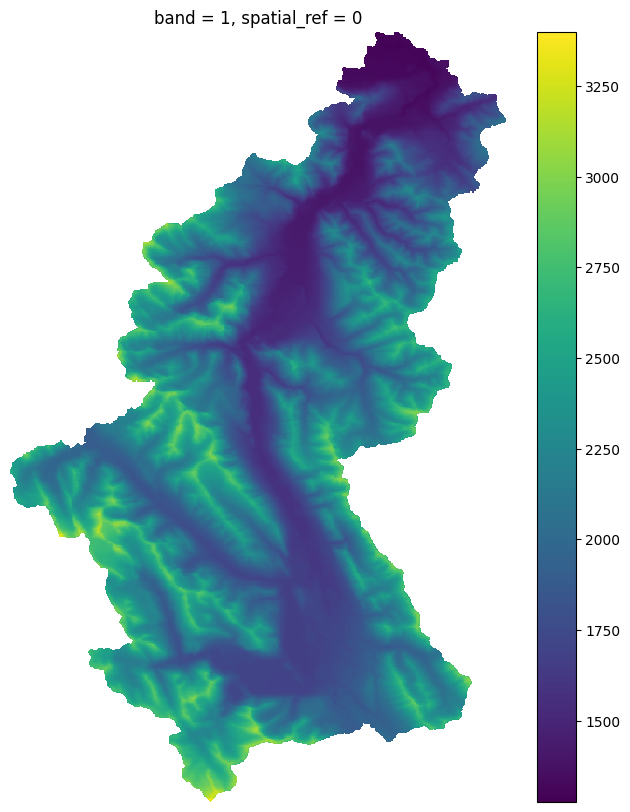


Minimum Elevation:  1275
Maximum Elevation:  3399
Mean Elevation:  2059
---------------------------------------------- Slope Layer ----------------------------------------------


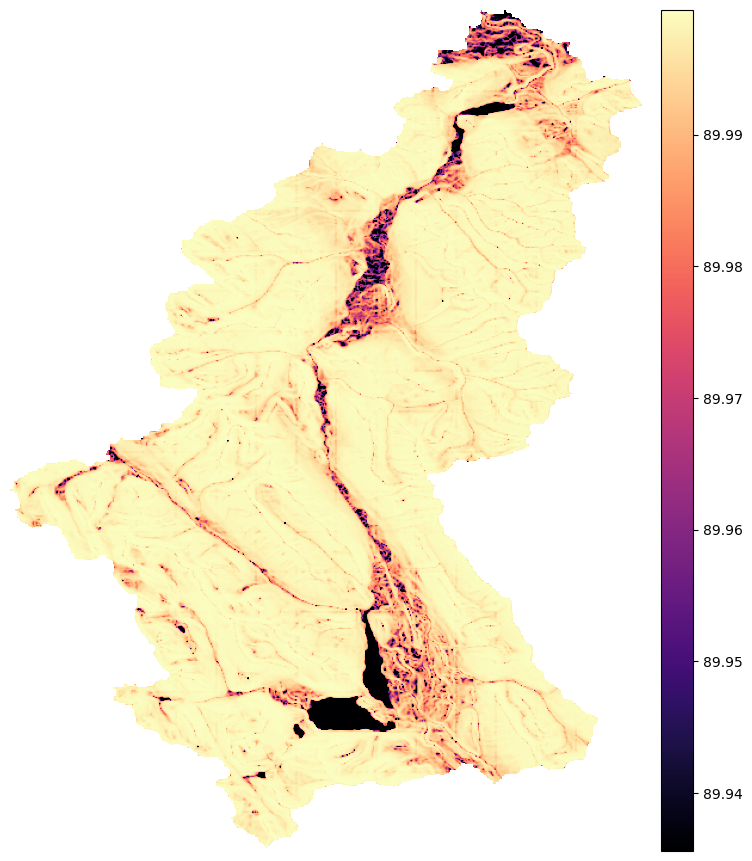


Minimum Slope:  79
Maximum Slope:  89
Mean Slope:  89
---------------------------------------------- Aspect Layer ----------------------------------------------


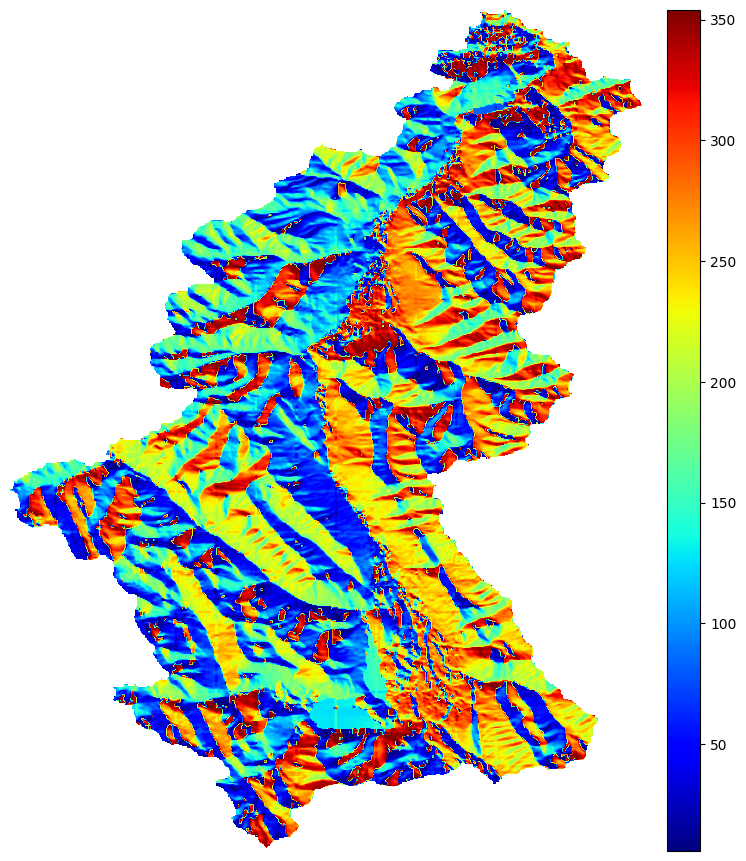


Minimum aspect:  0
Maximum aspect:  359
Mean aspect:  176

-----------------------------------------------------------------------------------------------
(4) DEM Complete!
-----------------------------------------------------------------------------------------------


In [11]:
if variable['generate_DEM'] == "yes" and variable['upload_DEM'] == "yes":
  print('Error: Please define whether you are using section 1b to generate the DEM layer OR upload your own, users cannot have both set as yes')
elif variable['generate_DEM'] == 'yes' and variable['upload_DEM'] == "no":
  shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
  # step 1
  check_projection(shp_file_path)
  # step 2
  download_DEM(shp_file_path,variable["data_source_dem"], variable["band_name_dem"], int(variable['scale_dem']))
  # step 3
  format_and_visualize_dem(shp_file_path)
  # step 4
  visualize_dem(variable['DEM_visualize'], variable['Slope_visualize'], variable['Aspect_visualize'], variable['save_shp_of_aspect'])
  #step 5
  remove_temp_data()
elif variable['generate_DEM'] == "no" and variable['upload_DEM'] == "yes":
  dem_temp_dir = os.path.join(variable['temporary_dir'],'DEM')
  if not os.path.exists(dem_temp_dir):
    os.makedirs(dem_temp_dir)
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Upload DEM')
  print('-----------------------------------------------------------------------------------------------')
  print(f'drag-and-drop DEM file into following folder: {dem_temp_dir}')
  response = input("Have you uploaded the DEM (.tif) file (yes or no): ")
  if response == "yes":
    shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
    # step 1
    check_projection(shp_file_path)
    # step 2
    format_and_visualize_dem(shp_file_path)
    # step 3
    visualize_dem(variable['DEM_visualize'], variable['Slope_visualize'], variable['Aspect_visualize'], variable['save_shp_of_aspect'])
    #step 4
    remove_temp_data()
else:
  print('( ) DEM section has been skipped')